In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa

In [2]:
#define figure space and set up
matplotlib.rcParams['figure.figsize'] = (15, 9)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'top',
      }
label_config_y = {'fontsize'            : 'xx-large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'}
matplotlib.rc('font', **font)

In [3]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [4]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df.iloc[:,0]:
        if "_" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [5]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [6]:
def no_hit_bed_addition(reference_bed_df, results_bed_df):
    """
    Function that compares reference bed with hit bed and adds missing zero
    cover bed intervals to the results_bed.
    """
    ref_df = reference_bed_df[:]
    res_df = results_bed_df[:]
    ref_df["Total-ID"] = ref_df[ref_df.columns.tolist()[0]].apply(str) + ref_df[ref_df.columns.tolist()[1]].apply(str)
    res_df["Total-ID"] = res_df[res_df.columns.tolist()[0]].apply(str) + res_df[res_df.columns.tolist()[1]].apply(str)
    no_hit_list = list(set(ref_df["Total-ID"])- set(res_df["Total-ID"]))
    if len(no_hit_list) != 0:
        no_hit_df = ref_df[ref_df["Total-ID"].apply(lambda x: x in no_hit_list)]
        
        no_hit_df[results_bed_df.columns.tolist()[3]] = pd.Series([0]*len(no_hit_df))
        no_hit_df[results_bed_df.columns.tolist()[4]] = pd.Series([0]*len(no_hit_df))
        del no_hit_df["Total-ID"]
        del res_df["Total-ID"]
        no_hit_df = no_hit_df.rename(columns=dict(zip(no_hit_df.columns.tolist(), res_df.columns.tolist())))
        res_df = res_df.append(no_hit_df)
        res_df = res_df.sort_values(by=[res_df.columns.tolist()[0],res_df.columns.tolist()[1]]).reset_index(drop=True)
    else:
        del res_df["Total-ID"]
    res_df.rename(columns=dict(zip(res_df.columns.tolist(), results_bed_df.columns.tolist())))
    return res_df.fillna(0)

In [7]:
def bed_df_generator(file_path, file_name):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    bed_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-bed", "start", 'stop']
    #rename the headear according bed file output
    rename = dict(zip(bed_df.columns, header_cov))
    bed_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    return bed_df.sort_values(by=[bed_df.columns.tolist()[0],bed_df.columns.tolist()[1]]).reset_index(drop=True)
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [8]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #sort by column 1 and 2 in if one contig is split up into multiple parts in bed file
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0],coverage_df.columns.tolist()[1]]).reset_index(drop=True)
    return coverage_df


In [9]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    #coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    #sort by column 1 and 2 in if one contig is split up into multiple parts in bed file
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0],coverage_df.columns.tolist()[1]]).reset_index(drop=True)
    return coverage_all_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [10]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/'
g_preffix = 'v91_cns_ph_ctg'
p_and_a_ctg_file_name = g_preffix + '.fa'


In [11]:
#define used bed files p and pa
bed_path = p_and_a_ctg_path + '/BED'
bed_file_p= g_preffix + '_p_ctg.1000.bed'
bed_file_pa=g_preffix + '.1000.bed'

In [12]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path=p_and_a_ctg_path + '/LRM'
cov_file_name= g_preffix+ '_all_pbreads.bam.1000.cov'
seq_type='PacBio'
cov_file_p_PacBio= g_preffix+ '_all_pbreads.bam.1000.cov'


In [13]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path_2 =p_and_a_ctg_path + '/SRM'
cov_file_name_2=g_preffix+'.folder_5_ete.sam.sorted.bam.1000.cov'
seq_type_2='Illumina'

In [14]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
#FIXLATER
cov_path_3 = cov_path_2
cov_file_name_3=g_preffix+'_p_ctg.folder_5_ete.sam.sorted.bam.1000.cov'
seq_type_3='Illumina'

In [15]:
reference_contig_df = make_contig_df(p_and_a_ctg_path, p_and_a_ctg_file_name)

In [16]:
reference_bed_p = bed_df_generator(bed_path, bed_file_p)

In [17]:
reference_bed_pa = bed_df_generator(bed_path, bed_file_pa)

In [18]:
cov_1000_SRM_f5_pa = P_and_A_identifier(coverage_df_generator(cov_path_2, cov_file_name_2, seq_type_2))

In [19]:
cov_1000_SRM_f5_p = P_and_A_identifier(coverage_df_generator(cov_path_3, cov_file_name_3, seq_type_3))

In [20]:
#missing for now
cov_1000_Pac_bio_p = P_and_A_identifier(no_hit_bed_addition(reference_bed_p, coverage_df_generator(cov_path, cov_file_p_PacBio, seq_type)))

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


missing for now not done yet

In [21]:
cov_1000_Pac_bio_pa = P_and_A_identifier(no_hit_bed_addition(reference_bed_pa, coverage_df_generator(cov_path, cov_file_name, seq_type)))

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
len(reference_bed_pa) == len(cov_1000_Pac_bio_pa)

True

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


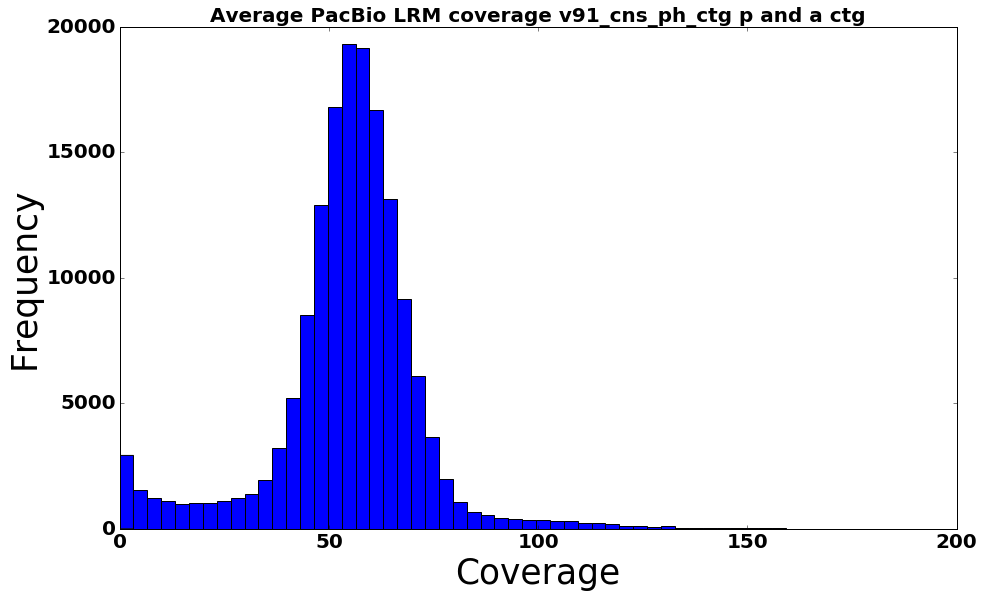

In [23]:
cov_1000_Pac_bio_pa[(cov_1000_Pac_bio_pa['Average Coverage PacBio'] >= 0) & (cov_1000_Pac_bio_pa['Average Coverage PacBio'] < 200)]['Average Coverage PacBio'].plot.hist(bins=60)
plt.title("Average PacBio LRM coverage " +g_preffix + " p and a ctg", **font)
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


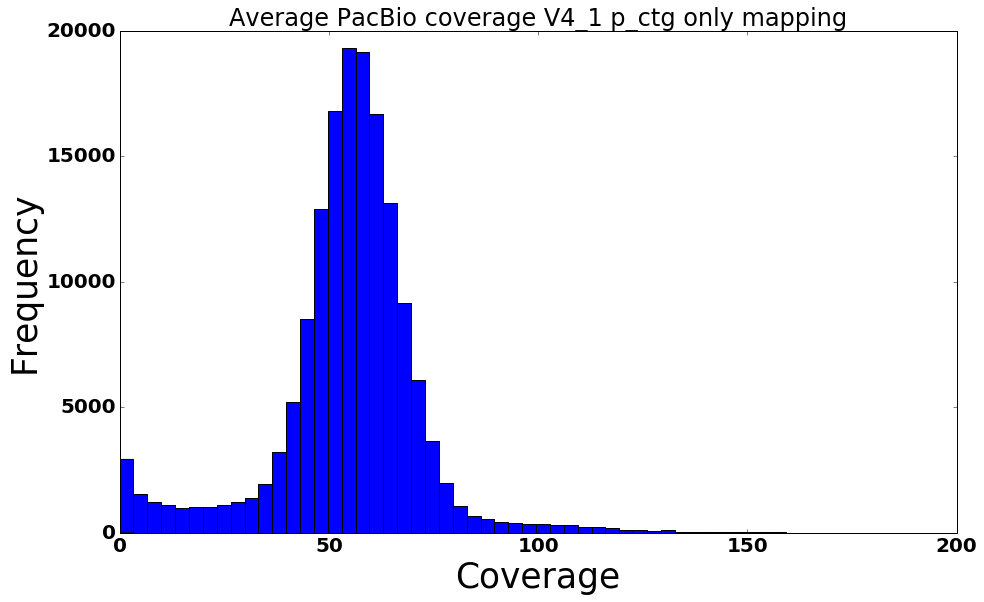

In [24]:
cov_1000_Pac_bio_p[(cov_1000_Pac_bio_p['Average Coverage PacBio'] >= 0) & (cov_1000_Pac_bio_p['Average Coverage PacBio'] < 200)]['Average Coverage PacBio'].plot.hist(bins=60)
plt.title("Average PacBio coverage V4_1 p_ctg only mapping")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

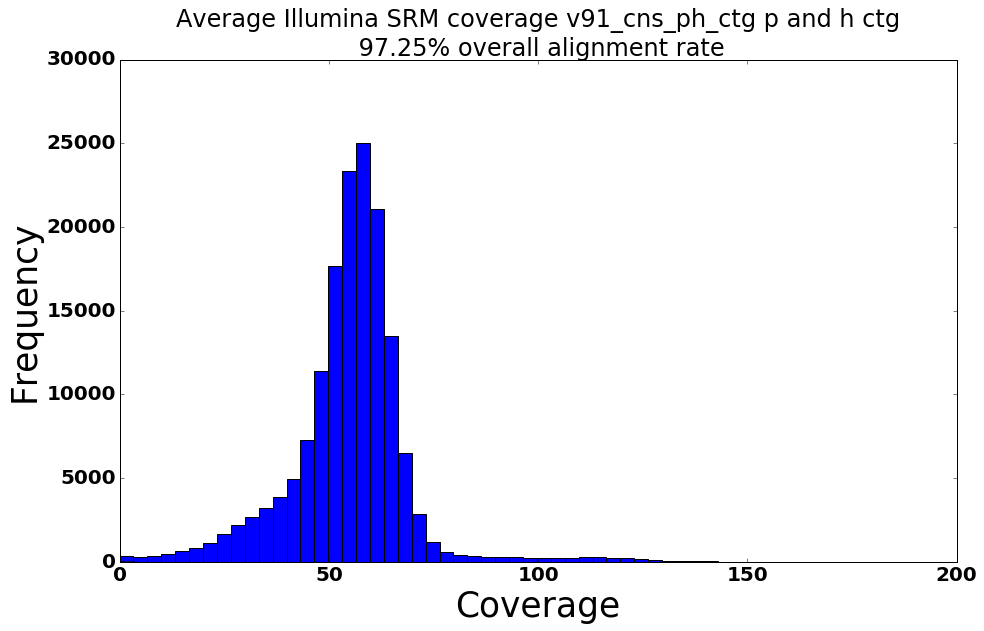

In [25]:
cov_1000_SRM_f5_pa[(cov_1000_SRM_f5_pa['Average Coverage Illumina'] >= 0) & (cov_1000_SRM_f5_pa['Average Coverage Illumina'] < 200)]['Average Coverage Illumina'].plot.hist(bins=60)
plt.title("Average Illumina SRM coverage " + g_preffix+ " p and h ctg\n 97.25% overall alignment rate")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)


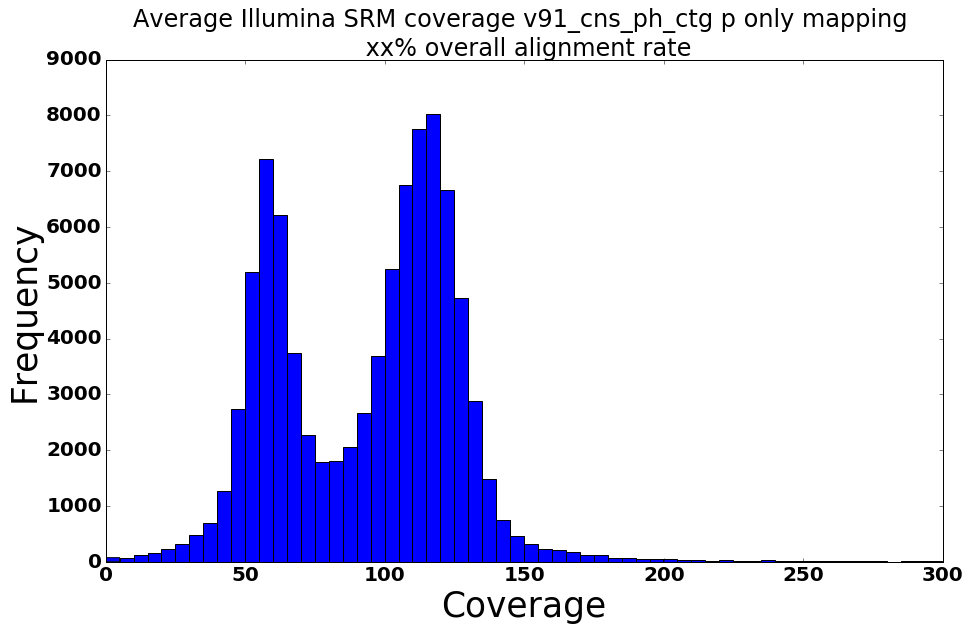

In [26]:
cov_1000_SRM_f5_p[(cov_1000_SRM_f5_p['Average Coverage Illumina'] >= 0) & (cov_1000_SRM_f5_p['Average Coverage Illumina'] < 300)]['Average Coverage Illumina'].plot.hist(bins=60)
plt.title("Average Illumina SRM coverage " +g_preffix+ " p only mapping \n xx% overall alignment rate")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)


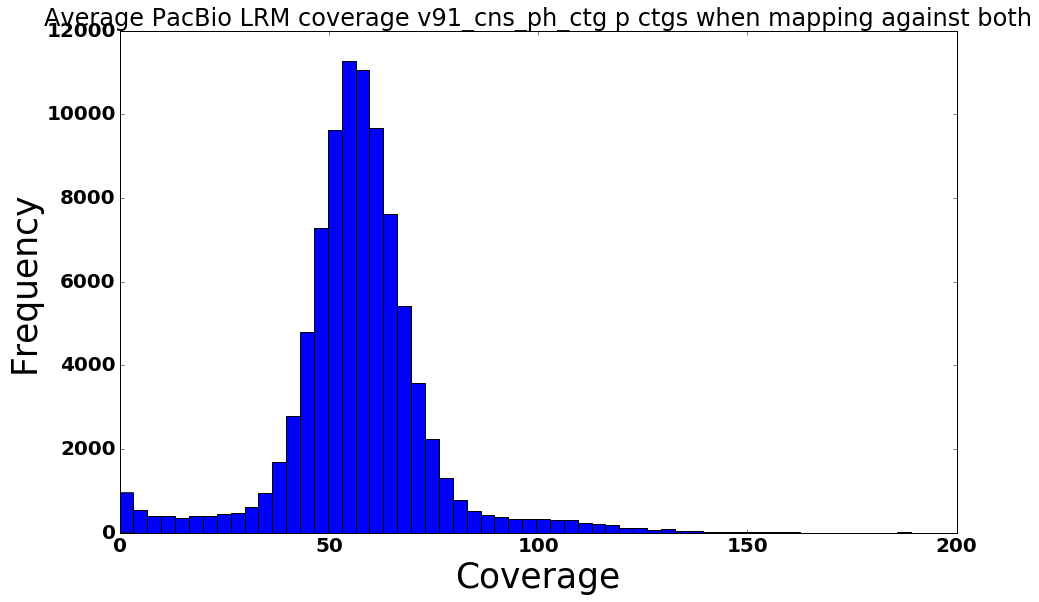

In [27]:
cov_1000_Pac_bio_pa[(cov_1000_Pac_bio_pa['Average Coverage PacBio'] >= 0) & (cov_1000_Pac_bio_pa['Average Coverage PacBio'] < 200) & (cov_1000_Pac_bio_pa['P_contig'] == 1)]['Average Coverage PacBio'].plot.hist(bins=60)
plt.title("Average PacBio LRM coverage " +g_preffix +" p ctgs when mapping against both")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

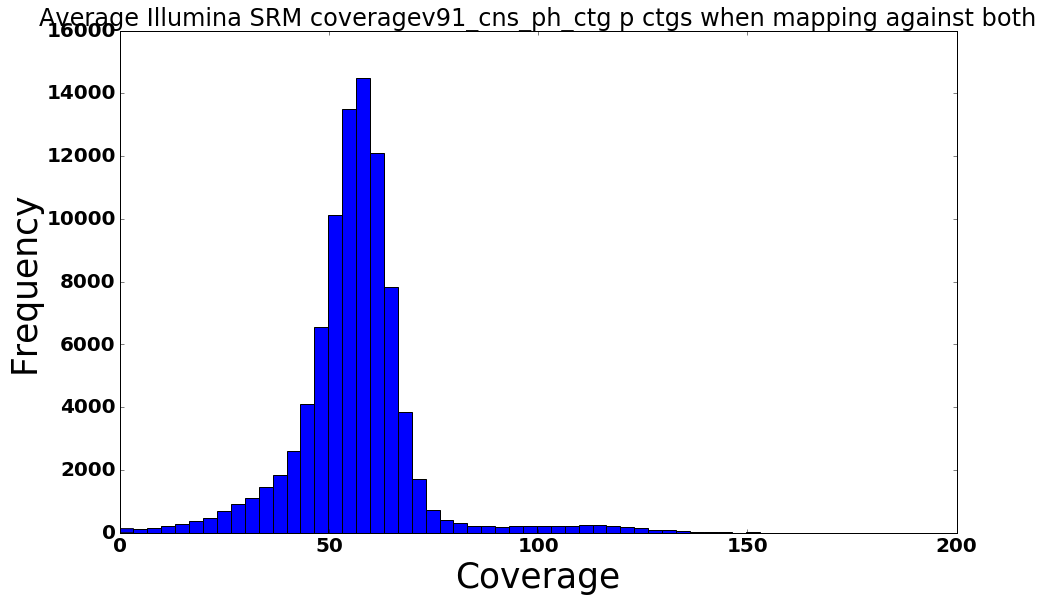

In [28]:
cov_1000_SRM_f5_pa[(cov_1000_SRM_f5_pa['Average Coverage Illumina'] >= 0) & (cov_1000_SRM_f5_pa['Average Coverage Illumina'] < 200) & (cov_1000_SRM_f5_pa['P_contig']==1)]['Average Coverage Illumina'].plot.hist(bins=60)
plt.title("Average Illumina SRM coverage" +g_preffix+  " p ctgs when mapping against both")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

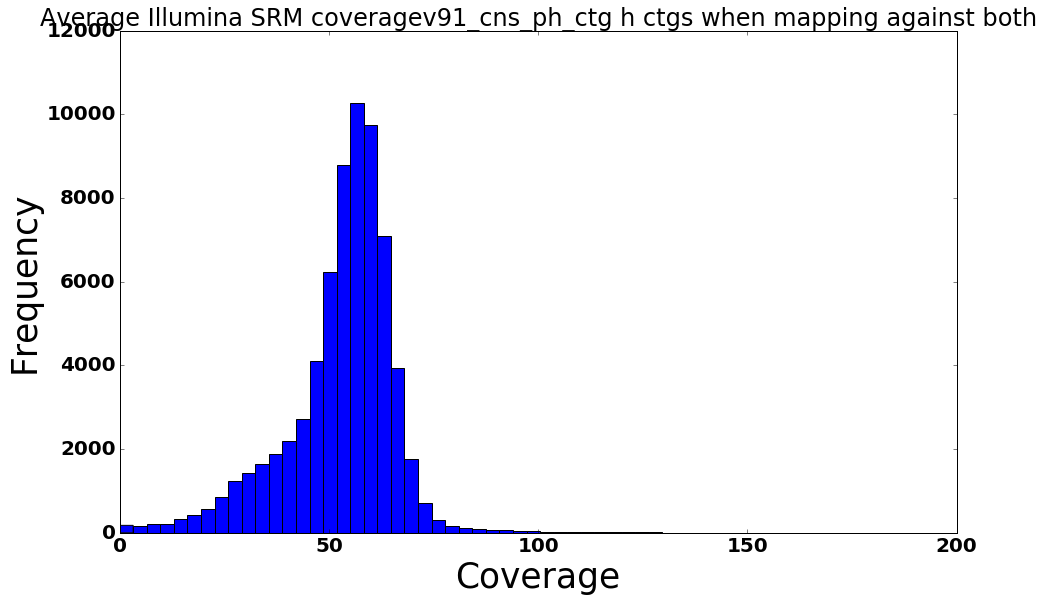

In [29]:
cov_1000_SRM_f5_pa[(cov_1000_SRM_f5_pa['Average Coverage Illumina'] >= 0) & (cov_1000_SRM_f5_pa['Average Coverage Illumina'] < 200) & (cov_1000_SRM_f5_pa['P_contig']==0)]['Average Coverage Illumina'].plot.hist(bins=60)
plt.title("Average Illumina SRM coverage" + g_preffix+ " h ctgs when mapping against both")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

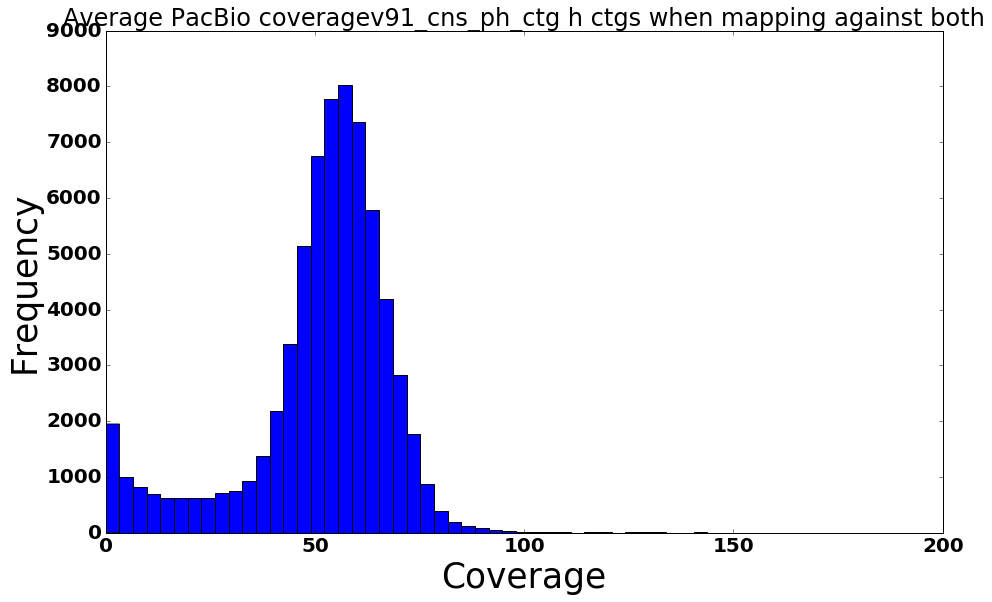

In [30]:
cov_1000_Pac_bio_pa[(cov_1000_Pac_bio_pa['Average Coverage PacBio'] >= 0) & (cov_1000_Pac_bio_pa['Average Coverage PacBio'] <200) & (cov_1000_Pac_bio_pa['P_contig'] == 0)]['Average Coverage PacBio'].plot.hist(bins=60)
plt.title("Average PacBio coverage" + g_preffix+ " h ctgs when mapping against both")
plt.xlabel("Coverage", **label_config_x)
plt.ylabel("Frequency", **label_config_y)

If you have an overlap between low coverage region in the p_and_a_ctg mapping and the p_ctg mapping. Those are truely heterozygous region. Which might well have different gene content etc.

In [31]:
cov_1000_Pac_bio_pa["ID-cov"] = cov_1000_Pac_bio_pa["ID-cov PacBio"].apply(lambda x: x.split('|')[0])

In [32]:
cov_1000_SRM_f5_pa["ID-cov"] = cov_1000_SRM_f5_pa["ID-cov Illumina"].apply(lambda x: x.split('|')[0])

In [33]:
cov_1000_SRM_f5_p["ID-cov"] = cov_1000_SRM_f5_p["ID-cov Illumina"].apply(lambda x: x.split('|')[0])

(0, 300)

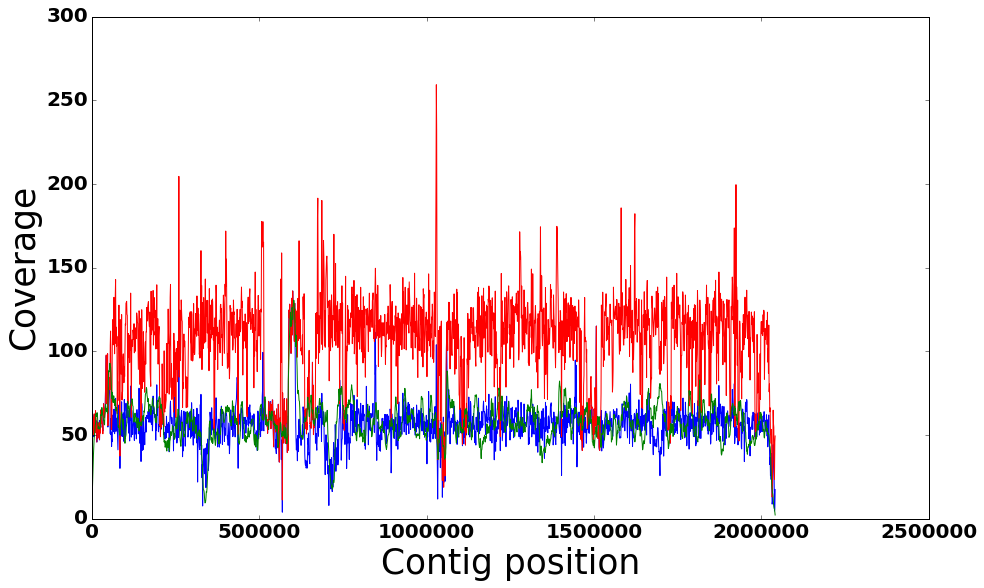

In [34]:
plt.figure(figsize=(15,9))
plt.plot(cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov"]=='000006F']['start Illumina'], cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov"]=='000006F']['Average Coverage Illumina'], 'k', c='b' )
plt.plot(cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov"]=='000006F']['start Illumina'], cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov"]=='000006F']['Average Coverage Illumina'], 'k', c='r' )
plt.plot(cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov"]=='000006F']['start PacBio'], cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov"]=='000006F']['Average Coverage PacBio'], 'k', c='g' )
#plt.plot(entero_Bac_contig_Pac_bio['start PacBio'], entero_Bac_contig_Pac_bio['Average Coverage PacBio'], 'k', c='b')
plt.xlabel("Contig position", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
plt.ylim(0,300)
#plt.xlim(cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]=='000003F']['start Illumina'].min(),cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]=='000003F']['start Illumina'].max())
#plt.xlim(1000000, 2000000) <- this was for #3

In [31]:
cov_1000_SRM_f5_pa.head()

,ID-cov Illumina,start Illumina,stop Illumina,total hits Illumina,Average Coverage Illumina,P_contig,A_contig,ID-cov
0,000000F,0,1000,10921,10.921,1,0,000000F
1,000000F,1000,2000,491,0.491,1,0,000000F
2,000000F,2000,3000,5182,5.182,1,0,000000F
3,000000F,3000,4000,1155,1.155,1,0,000000F
4,000000F,4000,5000,42116,42.116,1,0,000000F


In [32]:
cov_1000_SRM_f5_p["Average Coverage Illumina"].mean()

131.6679075946341

In [33]:
cov_1000_SRM_f5_pa["Average Coverage Illumina"].mean()

78.20033805083318

cov_1000_Pac_bio_pa["Average Coverage PacBio"].mean()

cov_1000_Pac_bio_pa["Average Coverage PacBio"].median()

In [34]:
cov_1000_SRM_f5_pa["Average Coverage Illumina"].median()

56.495

plt.plot(range(0,len(cov_1000_Pac_bio_pa)), cov_1000_Pac_bio_pa.sort_values(by=["P_contig", "ID-cov"])["Average Coverage PacBio"])
plt.ylim(0,300)

In [ ]:
!pwd

In [35]:
#set mummur directory
mummer_dir= p_and_a_ctg_path

In [36]:
 y, files  = os.walk(mummer_dir, topdown=False)

In [37]:
#get all gcoord files
gcoords =  [x for x in files[2] if x[-7:] == 'gcoords']

In [38]:
#get all p_ctgs
p_ctgs = set(cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa['P_contig'] == 1]["ID-cov Illumina"])

In [39]:
#set output directory
outdir = p_and_a_ctg_path + '/plots'

In [42]:
%matplotlib osx
for p_ctg in p_ctgs:
    plt.figure()
    #plt.plot(cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['start Illumina'], cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'], 'k', c='r' )
    plt.plot(cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['start Illumina'], cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'], 'k', c='b' )
    #plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    #plt.plot(cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['start PacBio'], cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['Average Coverage PacBio'], 'k', c='g' )
    #plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    p_ctg_gcoords = []
    p_ctg_gcoords = [x for x in gcoords if p_ctg.split('|')[0] in x]
    mummer_df_tmp = pd.DataFrame()
    max_f5_pa = cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].max()
    max_f5_p = cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].max()
    #max_PB_pa = cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['Average Coverage PacBio'].max()
    #max_1_1 = 1.1*sorted([max_f5_pa, max_f5_p,max_PB_pa])[-1]
    max_1_1 = 1.1*max_f5_pa
    if p_ctg_gcoords != []:
        #print (p_ctg_gcoords)
        mummer_df_tmp = pd.read_csv(mummer_dir+'/'+p_ctg_gcoords[0], sep='\t', header=None,skiprows=4 )
        header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-a"]
        rename = dict(zip(mummer_df_tmp.columns, header_mum))
        mummer_df_tmp.rename(columns=rename,inplace=True)
        tmp = mummer_df_tmp[mummer_df_tmp['ID-p'] ==p_ctg]["S1"].tolist()
        tmp2 = mummer_df_tmp[mummer_df_tmp['ID-p'] ==p_ctg]["E1"].tolist() 
        for (x,y) in zip(tmp,tmp2):
            mean_3 = 3*cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].mean()
            set_point = mean_3
            if mean_3 > max_1_1:
                set_point = max_1_1
            plt.plot((x,y), (set_point, set_point), 'k-', ms=4)
    plt.xlabel("Contig position", **label_config_x)
    plt.ylabel('Coverage', **label_config_y)
    plt.title(p_ctg)
    #fix this part in case PacBio is higher than illumina
    plt.ylim(0, 1.2*max_1_1)
    plt.xlim(-cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['stop Illumina'].max()*0.01, cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['stop Illumina'].max()*1.01)
    plt.savefig(outdir+"/"+p_ctg.split('|')[0]+'ph_gcoords.png',dpi=300)
    plt.close()
    #plt.ylim(0,300)

In [40]:
cov_1000_SRM_f5_p.head()

,ID-cov Illumina,start Illumina,stop Illumina,total hits Illumina,Average Coverage Illumina,P_contig,A_contig,ID-cov
0,000000F,0,1000,13883,13.883,1,0,000000F
1,000000F,1000,2000,1014,1.014,1,0,000000F
2,000000F,2000,3000,3743,3.743,1,0,000000F
3,000000F,3000,4000,1141,1.141,1,0,000000F
4,000000F,4000,5000,77016,77.016,1,0,000000F


In [43]:
%matplotlib osx
for p_ctg in p_ctgs:
    plt.figure()
    plt.plot(cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['start Illumina'], cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'], 'k', c='r' )
    plt.plot(cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['start Illumina'], cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'], 'k', c='b' )
    #plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    #plt.plot(cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['start PacBio'], cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['Average Coverage PacBio'], 'k', c='g' )
    #plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    p_ctg_gcoords = []
    p_ctg_gcoords = [x for x in gcoords if p_ctg.split('|')[0] in x]
    mummer_df_tmp = pd.DataFrame()
    max_f5_pa = cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].max()
    max_f5_p = cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].max()
    #max_PB_pa = cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov PacBio"]==p_ctg]['Average Coverage PacBio'].max()
    max_1_1 = 1.1*sorted([max_f5_pa, max_f5_p])[-1]
    if p_ctg_gcoords != []:
        #print (p_ctg_gcoords)
        mummer_df_tmp = pd.read_csv(mummer_dir+'/'+p_ctg_gcoords[0], sep='\t', header=None,skiprows=4 )
        header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-a"]
        rename = dict(zip(mummer_df_tmp.columns, header_mum))
        mummer_df_tmp.rename(columns=rename,inplace=True)
        tmp = mummer_df_tmp[mummer_df_tmp['ID-p'] ==p_ctg]["S1"].tolist()
        tmp2 = mummer_df_tmp[mummer_df_tmp['ID-p'] ==p_ctg]["E1"].tolist() 
        for (x,y) in zip(tmp,tmp2):
            mean_3 = 3*cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['Average Coverage Illumina'].mean()
            set_point = mean_3
            if mean_3 > max_1_1:
                set_point = max_1_1
            plt.plot((x,y), (set_point, set_point), 'k-', ms=4)
    plt.xlabel("Contig position", **label_config_x)
    plt.ylabel('Coverage', **label_config_y)
    plt.title(p_ctg)
    #fix this part in case PacBio is higher than illumina
    plt.ylim(0, 1.2*max_1_1)
    plt.xlim(-cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['stop Illumina'].max()*0.01, cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]==p_ctg]['stop Illumina'].max()*1.01)
    plt.savefig(outdir+"/"+p_ctg.split('|')[0]+'ph_and_p_only_.png',dpi=300)
    plt.close()

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]=='000000F']['start Illumina'], cov_1000_SRM_f5_p[cov_1000_SRM_f5_p["ID-cov Illumina"]=='000000F']['Average Coverage Illumina'], 'k', c='r' )
plt.plot(cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov"]=='000000F']['start Illumina'], cov_1000_SRM_f5_pa[cov_1000_SRM_f5_pa["ID-cov"]=='000000F']['Average Coverage Illumina'], 'k', c='b' )

#plt.legend(loc='center left', bbox_to_anchor=(1.2, 1.2))
plt.legend(['a','b','c'])
plt.xlabel("Contig position", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
plt.plot(cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov"]=='000000F']['start PacBio'], cov_1000_Pac_bio_pa[cov_1000_Pac_bio_pa["ID-cov"]=='000000F']['Average Coverage PacBio'], 'k', c='g' )
plt.legend(loc='center left', bbox_to_anchor=(1, 1))
for (x,y) in zip(tmp,tmp2):
    plt.plot((x,y), (200, 200), 'k-', ms=4)
plt.xlabel("Contig position", **label_config_x)
plt.ylabel('Coverage', **label_config_y)
plt.savefig(outdir+"/"+'test2.png',bbox_inches='tight', dpi=300)
#plt.ylim(0,300)

In [ ]:
?%matplotlib

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 9)
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 15}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'}
matplotlib.rc('font', **font)



In [ ]:
cov_1000_Pac_bio_pa[(cov_1000_Pac_bio_pa['Average Coverage PacBio'] >= 0) & (cov_1000_Pac_bio_pa['Average Coverage PacBio'] <200) & (cov_1000_Pac_bio_pa['P_contig'] == 0)]['Average Coverage PacBio'].plot.hist(bins=60)
plt.title("Average PacBio coverage v4_1 a ctgs when mapping against both")
plt.xlabel("Coverage")